바이크와 고급 주택 가격 머신러닝

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)  #런타임 오류 안뜨게 하는 것인듯?


## 자전거 대여 수요 예측

datetime : 날짜 및 시간 (타임스탬프)
seaseon : 봄 여름 가을 겨울 순서대로 1234
holiday : 휴일 True or False
workingday : 평일 True or False
weatehr : 날씨 (1 : 맑음,구름약간, 2 : 안개, 3: 눈 비 4 : 강한 눈 비)
temp : 온도 
atemp : 체감온도
humidity : 습도
windspeed : 풍속
casual : 미등록자 대여
registered : 등록자 대여
count : 대여 횟수

In [2]:
bikeDF = pd.read_csv('../data/bike_train.csv')
bikeDF.shape, bikeDF.head(3)

((10886, 12),
               datetime  season  holiday  workingday  weather  temp   atemp  \
 0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
 1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
 2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
 
    humidity  windspeed  casual  registered  count  
 0        81        0.0       3          13     16  
 1        80        0.0       8          32     40  
 2        80        0.0       5          27     32  )

In [3]:
bikeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# object => datetime 형변환
bikeDF['datetime'] = bikeDF.datetime.apply(pd.to_datetime)

# 각각 시간 속성으로 쪼개기
bikeDF['year'] = bikeDF.datetime.apply(lambda x:x.year) # 제가 참 람다랑 안친한데 말이죠. apply 다시 보기 ....
bikeDF['month'] = bikeDF.datetime.apply(lambda x:x.month)
bikeDF['day'] = bikeDF.datetime.apply(lambda x:x.day)
bikeDF['hour'] = bikeDF.datetime.apply(lambda x:x.hour)

bikeDF.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
bikeDF.drop(['datetime','casual','registered'], axis=1, inplace=True)

In [6]:
# 드랍 확인용 
bikeDF.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


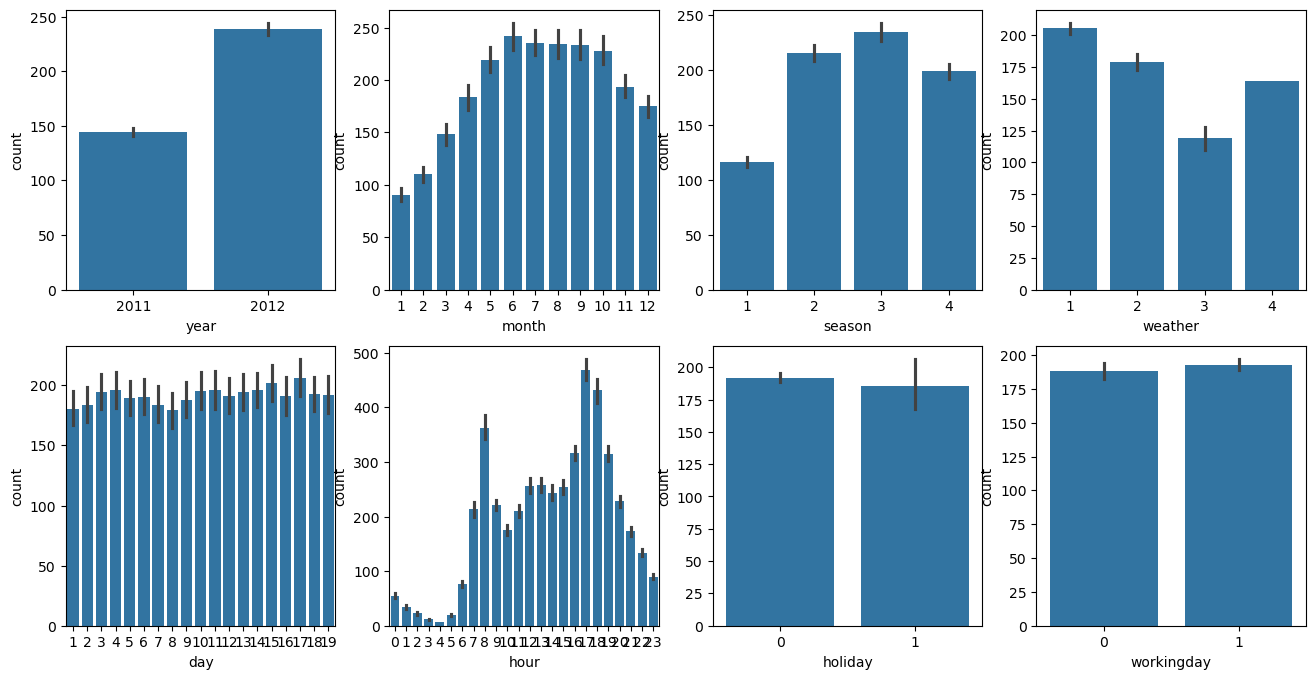

In [7]:
fig,axs = plt.subplots(figsize = (16,8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather','day','hour','holiday','workingday']

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4

    sns.barplot(x=feature, y='count', data=bikeDF, ax=axs[row][col])

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# RMSLE : Root Mean Squear Log Error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)

    mae_val = mean_absolute_error(y, pred)
    print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}'.format(rmsle_val, mae_val, rmse_val, mae_val))

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bikeDF['count']
X_feature = bikeDF.drop(['count'], axis =1)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 105.924, MAE : 140.900


In [10]:
# 예측값과 실제 값의 차이가 가장 큰 값 출력. 
def get_top_error_day(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_day(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

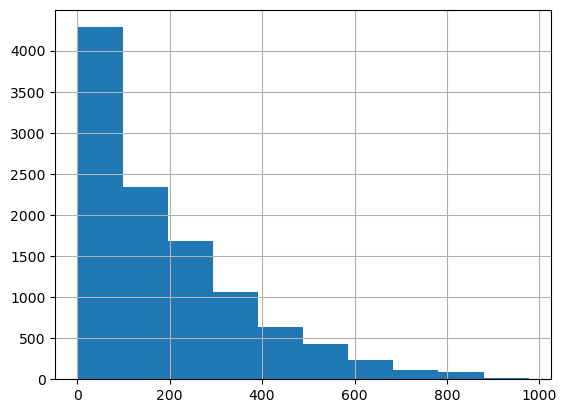

In [11]:
y_target.hist()

<Axes: >

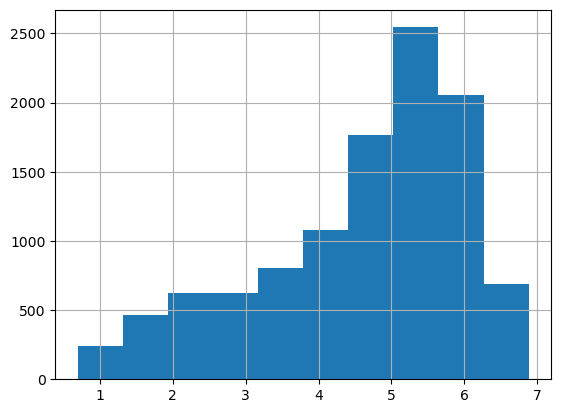

In [12]:
# 정규분포 형태가 아님. 정규분포로 만들어주기 위해 log1p로 count 분포 확인
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [13]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)

# expm1 <-> log1p 서로 반대 효과

In [14]:
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)
# 아까전에는 RMSLE : 1.165, RMSE : 105.924, MAE : 140.900
# 0에 가까워야ㅕ 좋다 !!!!!

RMSLE : 1.017, RMSE : 109.286, MAE : 162.594


<Axes: ylabel='None'>

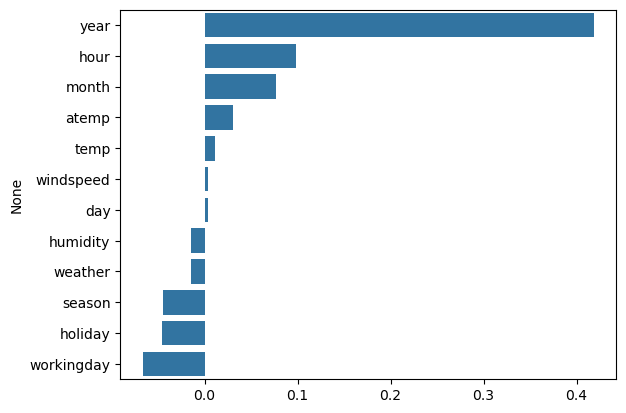

In [15]:
coef = pd.Series(lr_reg.coef_, index = X_feature.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [16]:
# 원핫인코딩 방법 get_dummies()

X_feature_ohe = pd.get_dummies(X_feature, columns=['year','month','day','hour','holiday','workingday','season','weather'])


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_feature_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10) # 과대적합 방지용들, 릿지는 가중치 억제고 라쏘는 아예 0
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 63.382, MAE : 97.688
### Ridge ###
RMSLE : 0.590, RMSE : 63.893, MAE : 98.529
### Lasso ###
RMSLE : 0.635, RMSE : 72.803, MAE : 113.219


<Axes: ylabel='None'>

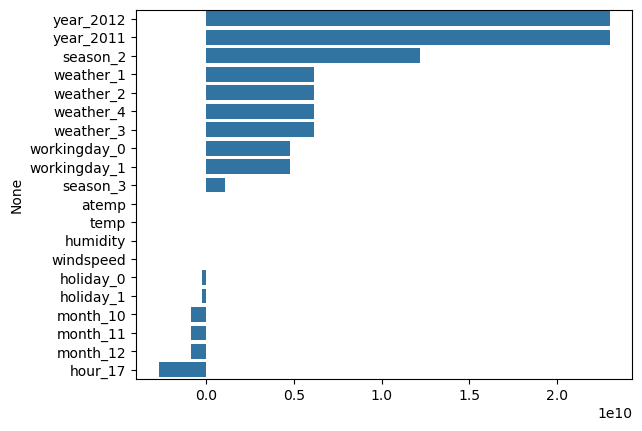

In [18]:
coef = pd.Series(lr_reg.coef_, index = X_feature_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [20]:
rf_reg = RandomForestClassifier(n_estimators=500)
gbm_reg = GradientBoostingClassifier(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.